#### REZIME PWOJÈ: DETEKSYON NEMONI AK ENTÈLIJANS ATIFISYÈL

#### 📌 Konprann Biznis la
Pwojè sa a vize devlope yon sistèm otomatik pou detekte nemoni nan imaj radyografi pwatrin yo ak entèlijans atifisyèl.  

**Stakeholder prensipal yo:** klinik ak lopital nan zòn riral Ayiti kote pa gen ase radyològ espesyalis.  

**Sous done:** dataset *Chest X-Ray Images (Pneumonia)* ki gen **5,856 imaj radyografi pwatrin**:
- Nòmal: **1,583 imaj**  
- Nemoni: **4,273 imaj**  


#### ⚙️ Preparasyon Done
- **Bibliyotèk:** TensorFlow/Keras ak *ImageDataGenerator*  
- **Divizyon:** antrennman (5,216 imaj), validasyon, ak tès  
- **Ogmantasyon imaj:**  
  - Wotasyon: 15°  
  - Deplasman orizontal/vètikal: 10%  
  - Zoom: 10%  
- **Pre-traitement:** tout imaj yo redimansyone nan **224x224 piksèl** epi nòmalize ant 0 ak 1.

#### 🧠 Modèlizasyon
Nou konstwi **2 modèl prensipal** ak TensorFlow/Keras:

1. **CNN de baz**  
   - 3 kouch konvolusyon  
   - 2 kouch dans  
   - *Dropout* pou evite overfitting  

2. **Modèl transfer learning (VGG16)**  
   - Pre-antrene sou *ImageNet*  
   - Kouch pèsonalize pou klasifikasyon binè  

**Paramèt antrennman:**  
- CNN de baz: Adam optimizer, *learning rate* = 0.001  
- VGG16: Adam optimizer, *learning rate* = 0.0001  
- **Callback yo:** *EarlyStopping* & *ReduceLROnPlateau*

#### 📊 Evalyasyon
- **Pèfòmans pi bon:** VGG16 transfer learning  
- Rezilta sou done tès yo:  
  - **Presizyon (Accuracy):** 0.923077  
  - **AUC:** 0.961369    
- **Metrik evalyasyon:**  
  - Matris konfizyon  
  - Rapò klasifikasyon  
  - Koub ROC  

👉 Metrik sa yo enpòtan paske yo bay yon mezi sou **sensitivite** ak **spesifisite**, ki se kle nan yon kontèks medikal.


In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [2]:
# ==============================================================================
# ENPÒTASYON BIBLIYOTÈK YO
# ==============================================================================
"""
Nan pati sa a, n ap enpòte tout bibliyotèk Python ke nou bezwen pou pwojè a:
- numpy, pandas: pou manipile done yo
- matplotlib, seaborn: pou fè vizualizasyon
- tensorflow/keras: pou konstwi ak antrene modèl aprantisaj pwofon
- sklearn: pou evalyasyon ak metrik
- PIL: pou trete imaj
"""
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')  # Kache avètisman ki pa enpòtan yo

# Bibliyotèk pou aprantisaj pwofon (Deep Learning)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from tensorflow.keras.optimizers import Adam

# Pou trete imaj
from PIL import Image
#!pip install opencv-python
import cv2  # pou Grad-CAM

# Pou evalyasyon modèl
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

# Fikse valè aleatwè pou repwodui rezilta yo
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# ==============================================================================
# KONFIGIRASYON AK CHEMEN DONE YO
# ==============================================================================
# Chemen prensipal kote done yo ye
DATA_PATH = Path(path)

# repètwa pou antrennman, tès ak validasyon
TRAIN_DIR = DATA_PATH / "chest_xray" / "train"
TEST_DIR = DATA_PATH / "chest_xray" / "test"
VAL_DIR = DATA_PATH / "chest_xray" / "val"

# Verifye si dosye yo egziste
print("VERIFIKASYON DOSYE YO")
print("-"*40)
for dir_path in [TRAIN_DIR, TEST_DIR, VAL_DIR]:
    if dir_path.exists():
        print(f"✓ {dir_path.name} egziste")
        # Konte kantite imaj nan chak klas
        normal_count = len(list((dir_path / "NORMAL").glob("*.jpeg")))
        pneumonia_count = len(list((dir_path / "PNEUMONIA").glob("*.jpeg")))
        print(f"  - Imaj Normal: {normal_count}")
        print(f"  - Imaj Nemoni: {pneumonia_count}")
        print(f"  - Total: {normal_count + pneumonia_count}\n")
    else:
        print(f"✗ ATANSYON: {dir_path} pa jwenn!")
        print("  Tanpri verifye chemen an oswa telechaje done yo\n")

VERIFIKASYON DOSYE YO
----------------------------------------
✓ train egziste
  - Imaj Normal: 1341
  - Imaj Nemoni: 3875
  - Total: 5216

✓ test egziste
  - Imaj Normal: 234
  - Imaj Nemoni: 390
  - Total: 624

✓ val egziste
  - Imaj Normal: 8
  - Imaj Nemoni: 8
  - Total: 16



In [4]:
# ==============================================================================
# EKSPLORASYON DONE YO
# ==============================================================================

"""
Fonksyon pou analize distribisyon klas yo nan yon seri done.

    Paramèt:
    - data_dir: Chemen kote done yo ye
    - non_done: Non seri done a (egzanp: 'Antrennman', 'Tès')

    Lap Retounen:
    - Yon DataFrame ak enfòmasyon sou done yo
"""

def analize_distribisyon(data_dir, non_done):
    # Jwenn tout imaj nan chak klas
    normal_imgs = list((data_dir / "NORMAL").glob("*.jpeg"))
    pneumonia_imgs = list((data_dir / "PNEUMONIA").glob("*.jpeg"))

    # Kreye DataFrame pou òganize enfòmasyon yo
    data = {
        'Klas': ['Normal'] * len(normal_imgs) + ['Nemoni'] * len(pneumonia_imgs),
        'Chemen': normal_imgs + pneumonia_imgs
    }
    df = pd.DataFrame(data)

    # Afiche estatistik
    print(f"\n DISTRIBISYON {non_done.upper()}")
    print("-"*40)
    distribisyon = df['Klas'].value_counts()
    print(distribisyon)

    # Kalkile pousantaj
    total = len(df)
    print(f"\nPousantaj chak klas yo:")
    for klas, kantite in distribisyon.items():
        pousan = (kantite / total) * 100
        print(f"  - {klas}: {pousan:.1f}%")

    # Detekte dezekilib
    ratio = pneumonia_imgs.__len__() / normal_imgs.__len__()
    print(f"\nRapò Nemoni/Normal: {ratio:.2f}:1")
    if ratio > 2:
        print("⚠️ATANSYON: Gen yon dezekilib enpòtan nan klas yo, ogmante done yo pou rezoud pwob sa!")

    return df

# Analize chak seri done
print("\n" + "="*60)
print("ANALIZ DISTRIBISYON DONE YO")
print("="*60)
train_df = analize_distribisyon(TRAIN_DIR, "Antrennman")
val_df = analize_distribisyon(VAL_DIR, "Validasyon")
test_df = analize_distribisyon(TEST_DIR, "Tès")


ANALIZ DISTRIBISYON DONE YO

 DISTRIBISYON ANTRENNMAN
----------------------------------------
Klas
Nemoni    3875
Normal    1341
Name: count, dtype: int64

Pousantaj chak klas yo:
  - Nemoni: 74.3%
  - Normal: 25.7%

Rapò Nemoni/Normal: 2.89:1
⚠️ATANSYON: Gen yon dezekilib enpòtan nan klas yo, ogmante done yo pou rezoud pwob sa!

 DISTRIBISYON VALIDASYON
----------------------------------------
Klas
Normal    8
Nemoni    8
Name: count, dtype: int64

Pousantaj chak klas yo:
  - Normal: 50.0%
  - Nemoni: 50.0%

Rapò Nemoni/Normal: 1.00:1

 DISTRIBISYON TÈS
----------------------------------------
Klas
Nemoni    390
Normal    234
Name: count, dtype: int64

Pousantaj chak klas yo:
  - Nemoni: 62.5%
  - Normal: 37.5%

Rapò Nemoni/Normal: 1.67:1


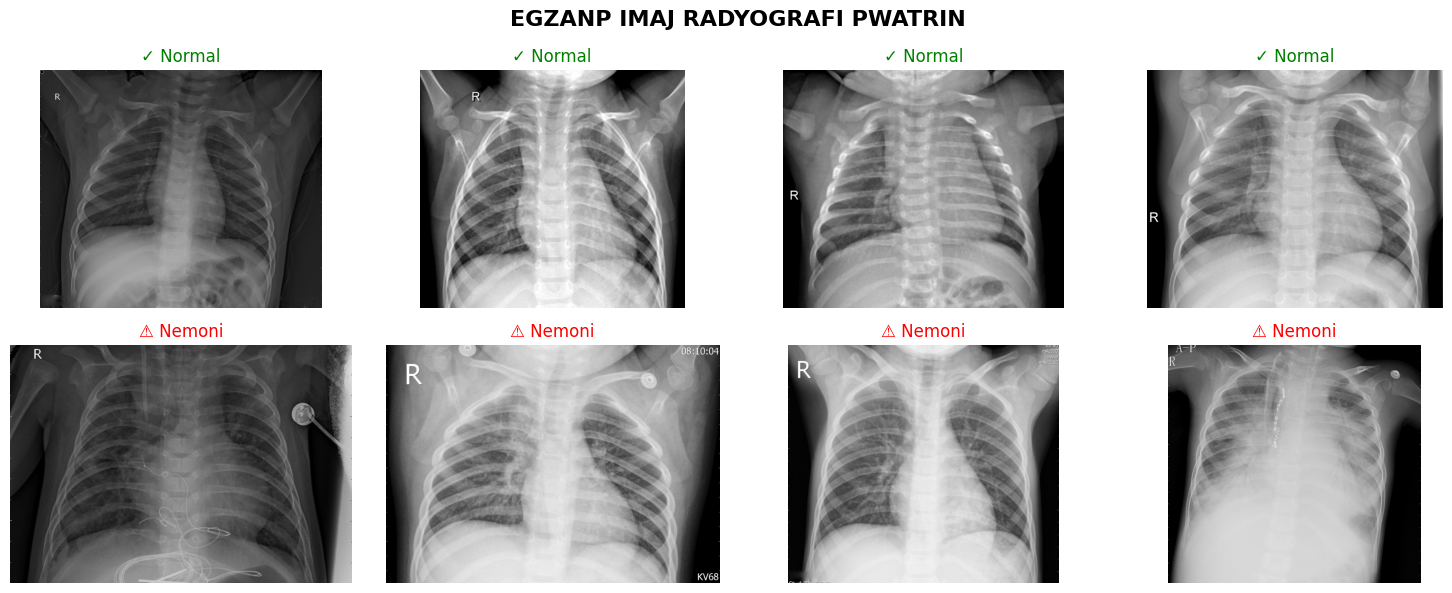

In [5]:
# ==============================================================================
# VIZUALIZASYON EGZANP IMAJ YO
# ==============================================================================

def montre_egzanp_imaj(data_dir, kantite=8):
    """
    Fonksyon pou montre kèk egzanp imaj radyografi.
    Sa pèmèt nou wè kalite imaj nou gen nan done yo.

    Paramèt:
    - data_dir: Kote imaj yo ye
    - kantite: Konbyen imaj pou montre
    """
    # Kreye yon figi ak plizyè espas pou imaj yo
    fig, axes = plt.subplots(2, kantite//2, figsize=(15, 6))
    fig.suptitle('EGZANP IMAJ RADYOGRAFI PWATRIN', fontsize=16, fontweight='bold')

    # Montre imaj normal yo sou premye liy lan
    normal_samples = list((data_dir / "NORMAL").glob("*.jpeg"))[:kantite//2]
    for i, img_path in enumerate(normal_samples):
        img = Image.open(img_path)
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title('✓ Normal', color='green')
        axes[0, i].axis('off')

    # Montre imaj nemoni yo sou dezyèm liy lan
    pneumonia_samples = list((data_dir / "PNEUMONIA").glob("*.jpeg"))[:kantite//2]
    for i, img_path in enumerate(pneumonia_samples):
        img = Image.open(img_path)
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].set_title('⚠️ Nemoni', color='red')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# call fonksyon an
montre_egzanp_imaj(TRAIN_DIR)



📐 ESTATISTIK DIMANSYON IMAJ (echantiyon 200 imaj)
--------------------------------------------------
Lajè - Mwayèn: 1427 piksèl, Devyasyon: 352
Wotè - Mwayèn: 1098 piksèl, Devyasyon: 384
Min/Max Lajè: 703/2633 piksèl
Min/Max Wotè: 375/2578 piksèl


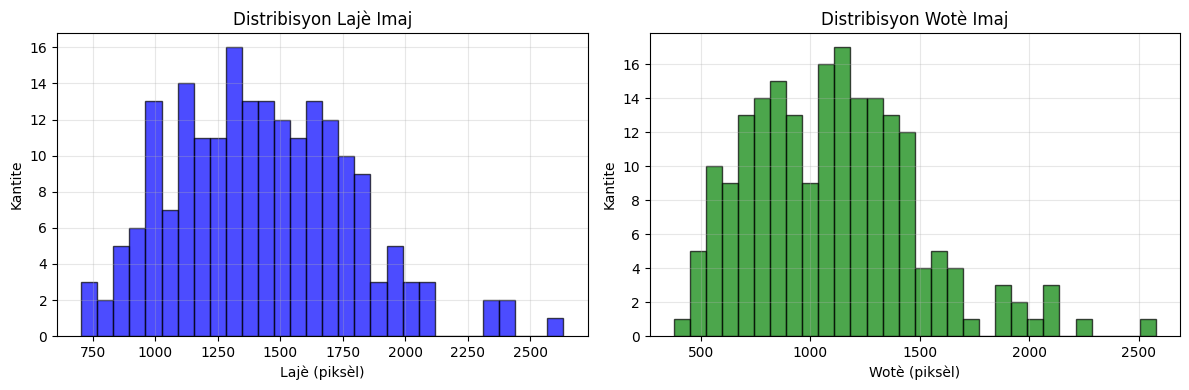

In [6]:
# ==============================================================================
# ANALIZ PWOPRIYETE IMAJ YO
# ==============================================================================

def analize_dimansyon_imaj(data_dir, echantiyon=100):
    """
    Fonksyon pou analize dimansyon imaj yo (lajè ak wotè).
    Sa enpòtan pou nou konnen si imaj yo gen menm gwosè.

    Paramèt:
    - data_dir: Kote imaj yo ye
    - echantiyon: Kantite imaj pou analize
    """
    lajè_yo = []
    wotè_yo = []

    # Analize imaj nan chak klas
    for klas in ['NORMAL', 'PNEUMONIA']:
        class_dir = data_dir / klas
        sample_imgs = list(class_dir.glob("*.jpeg"))[:echantiyon]

        for img_path in sample_imgs:
            img = Image.open(img_path)
            lajè_yo.append(img.width)
            wotè_yo.append(img.height)

    # Kalkile estatistik
    print(f"\n📐 ESTATISTIK DIMANSYON IMAJ (echantiyon {echantiyon*2} imaj)")
    print("-"*50)
    print(f"Lajè - Mwayèn: {np.mean(lajè_yo):.0f} piksèl, Devyasyon: {np.std(lajè_yo):.0f}")
    print(f"Wotè - Mwayèn: {np.mean(wotè_yo):.0f} piksèl, Devyasyon: {np.std(wotè_yo):.0f}")
    print(f"Min/Max Lajè: {min(lajè_yo)}/{max(lajè_yo)} piksèl")
    print(f"Min/Max Wotè: {min(wotè_yo)}/{max(wotè_yo)} piksèl")

    # Fè grafik distribisyon
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.hist(lajè_yo, bins=30, edgecolor='black', color='blue', alpha=0.7)
    ax1.set_title('Distribisyon Lajè Imaj')
    ax1.set_xlabel('Lajè (piksèl)')
    ax1.set_ylabel('Kantite')
    ax1.grid(True, alpha=0.3)

    ax2.hist(wotè_yo, bins=30, edgecolor='black', color='green', alpha=0.7)
    ax2.set_title('Distribisyon Wotè Imaj')
    ax2.set_xlabel('Wotè (piksèl)')
    ax2.set_ylabel('Kantite')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Analize dimansyon imaj yo
analize_dimansyon_imaj(TRAIN_DIR)

In [7]:
# ==============================================================================
# PREPARASYON DONE YO AK OGMANTASYON
# ==============================================================================

"""
Nan pati sa a, n ap prepare done yo pou antrennman:
1. Redimansyone tout imaj yo nan menm gwosè (224x224 : [Dimansyon estanda pou modèl CNN yo,Compatible ak modèl pre-trained yo])
2. Nòmalize valè piksèl yo ant 0 ak 1
3. Aplike ogmantasyon sou imaj antrennman pou amelyore modèl la
"""

# Defini paramèt imaj yo
IMG_HEIGHT = 224  # Wotè imaj la an piksèl
IMG_WIDTH = 224   # Lajè imaj la an piksèl
BATCH_SIZE = 32   # Kantite imaj pou trete ansanm

print("\n" + "="*60)
print("PREPARASYON DONE YO")
print("="*60)
print(f"Dimansyon imaj: {IMG_HEIGHT}x{IMG_WIDTH} piksèl")
print(f"Gwosè batch: {BATCH_SIZE} imaj")

# Kreye jeneratè pou done antrennman ak ogmantasyon
train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Nòmalize valè piksèl yo (0-255 → 0-1 paske CNN yo travay pi byen ak jan de ti valè sa yo)
    rotation_range=15,               # Wotasyon aleatwè jiska 15 degre
    width_shift_range=0.1,           # Deplase orizontal jiska 10%
    height_shift_range=0.1,          # Deplase vètikal jiska 10%
    shear_range=0.1,                 # Transfòmasyon shear
    zoom_range=0.1,                  # Zoom aleatwè jiska 10%
    horizontal_flip=True,            # Vire imaj la orizontalman
    fill_mode='nearest'             # Mòd ranpli pou piksèl nouvo
)

# Jeneratè pou validasyon ak tès san ogmantasyon
val_test_datagen = ImageDataGenerator(
    rescale=1./255  # Sèlman nòmalize, pa gen ogmantasyon
)

# Kreye jeneratè done yo
print("\nChaje done yo...")

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Klasifikasyon binè (2 klas yo :Normal/nemoni) )
    shuffle=True          # Melanje done yo
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Pa melanje pou validasyon
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Pa melanje pou tès
)

print(f"\n✓ Done yo chaje avèk siksè!")
print(f"Klas yo: {train_generator.class_indices}")


PREPARASYON DONE YO
Dimansyon imaj: 224x224 piksèl
Gwosè batch: 32 imaj

Chaje done yo...
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

✓ Done yo chaje avèk siksè!
Klas yo: {'NORMAL': 0, 'PNEUMONIA': 1}


In [8]:
# ==============================================================================
# KONSTWI MODÈL CNN DE BAZ
# ==============================================================================

def kreye_modèl_baz():
    """
    Fonksyon pou kreye yon modèl CNN senp kòm modèl de baz.
    Modèl sa a gen 3 kouch konvolusyon(yon kalkil matematik ki ajoute yon ti filtè sou imaj lapou detekte karaktèristik yo. ) ak 2 kouch dans.

    Achitèkti:
    - 3 blòk konvolusyon ak max pooling
    - 2 kouch dans ak dropout pou evite overfitting
    - Kouch final pou klasifikasyon binè
    """
    print("\n🔨 KONSTWI MODÈL CNN DE BAZ...")

    model = models.Sequential([
        # Premye blòk konvolusyon
        layers.Conv2D(32, (3, 3), activation='relu',
                     input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                     name='conv1'),
        layers.MaxPooling2D((2, 2), name='pool1'),

        # Dezyèm blòk konvolusyon
        layers.Conv2D(64, (3, 3), activation='relu', name='conv2'),
        layers.MaxPooling2D((2, 2), name='pool2'),

        # Twazyèm blòk konvolusyon
        layers.Conv2D(128, (3, 3), activation='relu', name='conv3'),
        layers.MaxPooling2D((2, 2), name='pool3'),

        # Aplati done yo pou kouch dans
        layers.Flatten(name='flatten'),

        # Premye kouch dans ak dropout
        layers.Dropout(0.5, name='dropout1'),  # 50% dropout pou evite overfitting
        layers.Dense(128, activation='relu', name='dense1'),

        # Dezyèm kouch dans ak dropout
        layers.Dropout(0.5, name='dropout2'),

        # Kouch final pou klasifikasyon binè
        layers.Dense(1, activation='sigmoid', name='output')  # Sigmoid pou pwobabilite
    ])

    # Konpile modèl la
    model.compile(
        optimizer=Adam(learning_rate=0.001),     # Optimizè Adam
        loss='binary_crossentropy',              # Fonksyon pèt pou binè
        metrics=['accuracy',                     # Presizyon
                tf.keras.metrics.AUC(name='auc')] # AUC (Area Under Curve)
    )

    print("✓ Modèl la kreye avèk siksè!")
    return model

# Kreye ak afiche modèl la
baseline_model = kreye_modèl_baz()
print("\nREZIME MODÈL DE BAZ:")
print("-"*50)
baseline_model.summary()


🔨 KONSTWI MODÈL CNN DE BAZ...
✓ Modèl la kreye avèk siksè!

REZIME MODÈL DE BAZ:
--------------------------------------------------


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# ==============================================================================
# ANTRENE MODÈL DE BAZ
# ==============================================================================

# Defini callback yo (fonksyon ki rele pandan antrennman)
callbacks = [
    # Rete antrennman si modèl la pa amelyore
    EarlyStopping(
        monitor='val_loss',           # Siveye pèt validasyon
        patience=5,                   # Tann 5 epòk anvan rete
        restore_best_weights=True,    # Restore pi bon pwa yo
        verbose=1                     # Afiche mesaj
    ),

    # Redui to aprantisaj si modèl la pa amelyore
    ReduceLROnPlateau(
        monitor='val_loss',           # Siveye pèt validasyon
        factor=0.5,                   # Miltiplye pa 0.5
        patience=3,                   # Tann 3 epòk
        min_lr=1e-7,                  # To minimòm
        verbose=1                     # Afiche mesaj
    )
]

print("\n" + "="*60)
print("ANTRENNMAN MODÈL DE BAZ")
print("="*60)
print("Antrennman ka pran yon ti tan...")

# Antrene modèl la
history_baseline = baseline_model.fit(
    train_generator,
    epochs=5,                        # Kantite epòk maksimòm
    validation_data=val_generator,    # Done validasyon
    callbacks=callbacks,              # Callback yo
    verbose=1                         # Afiche pwogresyon
)

print("\n✓ Antrennman fini avèk siksè!")


ANTRENNMAN MODÈL DE BAZ
Antrennman ka pran yon ti tan...
Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 165s 943ms/step - accuracy: 0.7440 - auc: 0.7284 - loss: 0.5652 - val_accuracy: 0.6250 - val_auc: 0.7969 - val_loss: 0.8685 - learning_rate: 0.0010
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 126s 774ms/step - accuracy: 0.8580 - auc: 0.9249 - loss: 0.3126 - val_accuracy: 0.8125 - val_auc: 0.8906 - val_loss: 0.6534 - learning_rate: 0.0010
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 774ms/step - accuracy: 0.8794 - auc: 0.9380 - loss: 0.2814 - val_accuracy: 0.7500 - val_auc: 0.9062 - val_loss: 0.6050 - learning_rate: 0.0010
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 126s 773ms/step - accuracy: 0.8961 - auc: 0.9469 - loss: 0.2604 - val_accuracy: 0.7500 - val_auc: 0.8672 - val_loss: 0.9777 - learning_rate: 0.0010
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 126s 773ms/step - accuracy: 0.9214 - auc: 0.9670 - loss: 0.2055 - val_accuracy: 0.8125 - val_auc: 0.9297 - val_loss: 0.5426 - learning_rate: 0.0010
Restori


📈 VIZUALIZASYON ANTRENNMAN - CNN de Baz


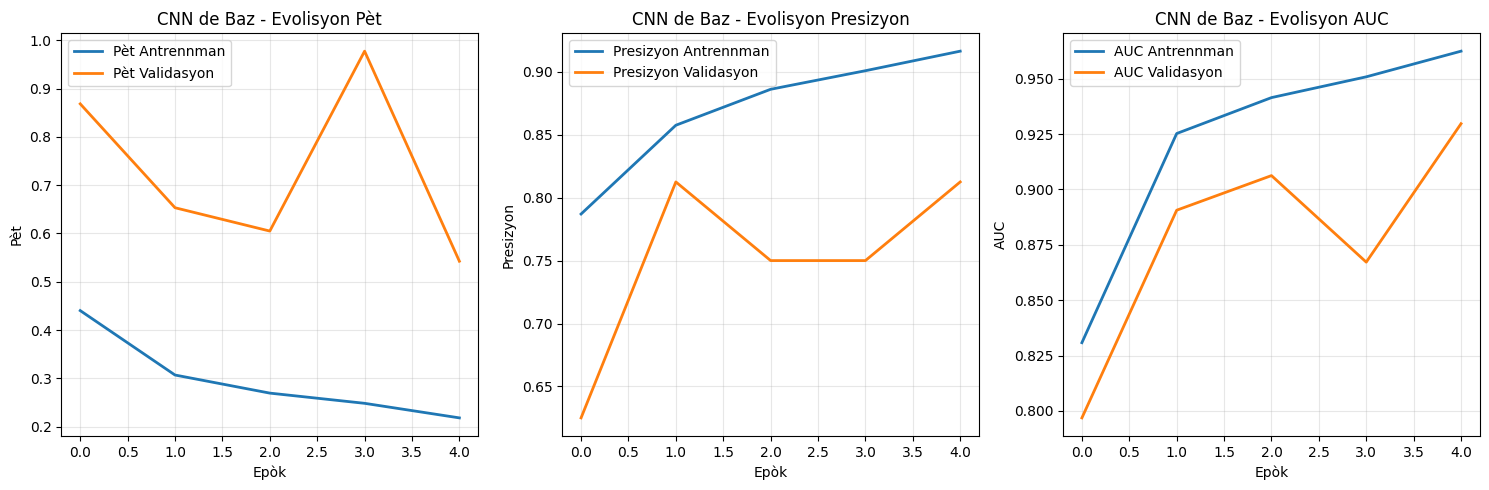

⚠️ ATANSYON: Gen risk overfitting eseye bal plis done antrennman


In [10]:
# ==============================================================================
#  VIZUALIZE ISTWA ANTRENNMAN
# ==============================================================================

def montre_istwa_antrennman(history, non_modèl="Modèl"):
    """
    Fonksyon pou montre evolisyon antrennman an.
    Sa pèmèt nou wè si modèl la ap aprann byen.

    Paramèt:
    - history: Objè ki gen istwa antrennman an
    - non_modèl: Non modèl la pou tit grafik yo
    """
    print(f"\n📈 VIZUALIZASYON ANTRENNMAN - {non_modèl}")

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Grafik 1: Evolisyon Pèt
    axes[0].plot(history.history['loss'], label='Pèt Antrennman', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Pèt Validasyon', linewidth=2)
    axes[0].set_title(f'{non_modèl} - Evolisyon Pèt')
    axes[0].set_xlabel('Epòk')
    axes[0].set_ylabel('Pèt')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Grafik 2: Evolisyon Presizyon
    axes[1].plot(history.history['accuracy'], label='Presizyon Antrennman', linewidth=2)
    axes[1].plot(history.history['val_accuracy'], label='Presizyon Validasyon', linewidth=2)
    axes[1].set_title(f'{non_modèl} - Evolisyon Presizyon')
    axes[1].set_xlabel('Epòk')
    axes[1].set_ylabel('Presizyon')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Grafik 3: Evolisyon AUC
    axes[2].plot(history.history['auc'], label='AUC Antrennman', linewidth=2)
    axes[2].plot(history.history['val_auc'], label='AUC Validasyon', linewidth=2)
    axes[2].set_title(f'{non_modèl} - Evolisyon AUC')
    axes[2].set_xlabel('Epòk')
    axes[2].set_ylabel('AUC')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Detekte overfitting
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    if final_val_loss > final_train_loss * 1.5:
        print("⚠️ ATANSYON: Gen risk overfitting eseye bal plis done antrennman")

# Montre istwa antrennman modèl de baz la
montre_istwa_antrennman(history_baseline, "CNN de Baz")

In [11]:
# ==============================================================================
# TRANSFER LEARNING AK MODÈL PRE-ANTRENE
# ==============================================================================

def kreye_modèl_transfer(non_modèl_baz='VGG16', kouch_antrenabl=2):
    """
    Fonksyon pou kreye yon modèl transfer learning.
    Transfer learning pèmèt nou itilize yon modèl ki deja antrene sou ImageNet
    epi adapte l pou pwoblèm nou an.

    Paramèt:
    - non_modèl_baz: Non modèl pre-antrene ('VGG16', 'ResNet50', 'EfficientNetB0')
    - kouch_antrenabl: Kantite kouch ki ka antrene nan modèl baz la
    """
    print(f"\n🚀 KREYE MODÈL TRANSFER LEARNING - {non_modèl_baz}")

    # Chaje modèl pre-antrene selon chwa a
    if non_modèl_baz == 'VGG16':
        base_model = VGG16(
            weights='imagenet',              # Pwa pre-antrene sou ImageNet
            include_top=False,               # Pa mete kouch klasifikasyon orijinal
            input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
        )
    elif non_modèl_baz == 'ResNet50':
        base_model = ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
        )
    elif non_modèl_baz == 'EfficientNetB0':
        base_model = EfficientNetB0(
            weights='imagenet',
            include_top=False,
            input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
        )

    # Jele kouch yo eksepte dènye yo
    # Sa pèmèt nou kenbe konesans modèl la deja gen
    for layer in base_model.layers[:-kouch_antrenabl]:
        layer.trainable = False

    # Ajoute kouch pèsonalize pou pwoblèm nou an
    model = models.Sequential([
        base_model,                                      # Modèl baz pre-antrene
        layers.GlobalAveragePooling2D(),                # Redui dimansyon
        layers.Dense(256, activation='relu'),           # Premye kouch dans
        layers.Dropout(0.5),                            # Dropout pou evite overfitting
        layers.Dense(128, activation='relu'),           # Dezyèm kouch dans
        layers.Dropout(0.3),                            # Plis dropout
        layers.Dense(1, activation='sigmoid')           # Kouch final binè
    ])

    # Konpile modèl la ak to aprantisaj pi ba
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # To pi ba paske gen kouch pre-antrene
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    print(f"✓ Modèl {non_modèl_baz} kreye avèk siksè!")
    print(f"  - Total kouch: {len(model.layers)}")
    print(f"  - Paramèt antrenabl: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")

    return model

# Kreye modèl VGG16 transfer learning
vgg_model = kreye_modèl_transfer('VGG16', kouch_antrenabl=4)
resnet_model = kreye_modèl_transfer('ResNet50', kouch_antrenabl=4)
efb_model = kreye_modèl_transfer('EfficientNetB0', kouch_antrenabl=4)


🚀 KREYE MODÈL TRANSFER LEARNING - VGG16
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
✓ Modèl VGG16 kreye avèk siksè!
  - Total kouch: 7
  - Paramèt antrenabl: 7,243,777

🚀 KREYE MODÈL TRANSFER LEARNING - ResNet50
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
✓ Modèl ResNet50 kreye avèk siksè!
  - Total kouch: 7
  - Paramèt antrenabl: 1,612,289

🚀 KREYE MODÈL TRANSFER LEARNING - EfficientNetB0
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
✓ Modèl EfficientNetB0 kreye avèk siksè!
  - Total kouch: 7
  - Paramèt antrenabl: 773,761



ANTRENNMAN MODÈL VGG16 TRANSFER LEARNING
Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 165s 873ms/step - accuracy: 0.8054 - auc: 0.8481 - loss: 0.3878 - val_accuracy: 0.6250 - val_auc: 0.8594 - val_loss: 1.4770 - learning_rate: 1.0000e-04
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 135s 825ms/step - accuracy: 0.9576 - auc: 0.9850 - loss: 0.1321 - val_accuracy: 0.7500 - val_auc: 1.0000 - val_loss: 0.6947 - learning_rate: 1.0000e-04
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 135s 827ms/step - accuracy: 0.9600 - auc: 0.9898 - loss: 0.1089 - val_accuracy: 0.7500 - val_auc: 1.0000 - val_loss: 0.7408 - learning_rate: 1.0000e-04
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 872ms/step - accuracy: 0.9694 - auc: 0.9939 - loss: 0.0855 - val_accuracy: 0.6875 - val_auc: 1.0000 - val_loss: 0.8370 - learning_rate: 1.0000e-04
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 136s 836ms/step - accuracy: 0.9735 - auc: 0.9950 - loss: 0.0738 - val_accuracy: 0.8750 - val_auc: 1.0000 - val_loss: 0.2370 - learning_rate: 1.0000e-04
Res

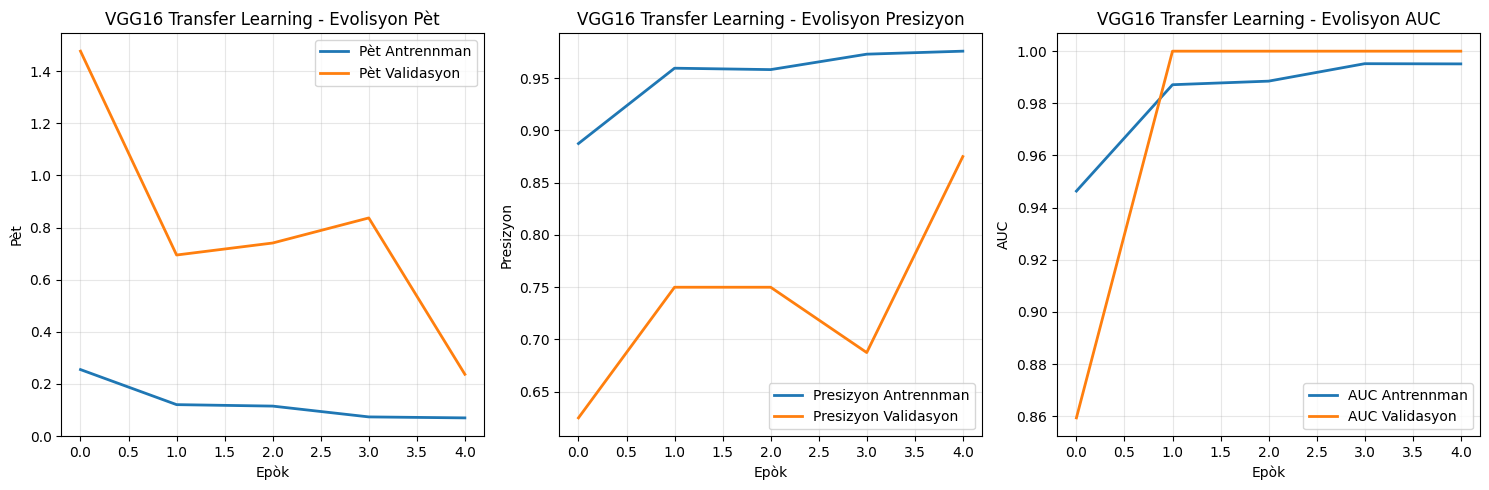

⚠️ ATANSYON: Gen risk overfitting eseye bal plis done antrennman


In [12]:
# ==============================================================================
# ANTRENE MODÈL TRANSFER LEARNING
# ==============================================================================

print("\n" + "="*60)
print("ANTRENNMAN MODÈL VGG16 TRANSFER LEARNING")
print("="*60)

history_vgg = vgg_model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Antrennman VGG16 fini avèk siksè!")
montre_istwa_antrennman(history_vgg, "VGG16 Transfer Learning")


Antrennman ResNet50 kòmanse...
Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 156s 833ms/step - accuracy: 0.7481 - auc: 0.6872 - loss: 0.5258 - val_accuracy: 0.5000 - val_auc: 0.8047 - val_loss: 0.7666 - learning_rate: 1.0000e-04
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 129s 790ms/step - accuracy: 0.8153 - auc: 0.8728 - loss: 0.3784 - val_accuracy: 0.6250 - val_auc: 0.8281 - val_loss: 0.7007 - learning_rate: 1.0000e-04
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 784ms/step - accuracy: 0.8395 - auc: 0.9043 - loss: 0.3386 - val_accuracy: 0.6875 - val_auc: 0.8359 - val_loss: 0.6749 - learning_rate: 1.0000e-04
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 784ms/step - accuracy: 0.8713 - auc: 0.9254 - loss: 0.2957 - val_accuracy: 0.6250 - val_auc: 0.8203 - val_loss: 1.0930 - learning_rate: 1.0000e-04
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 782ms/step - accuracy: 0.8803 - auc: 0.9369 - loss: 0.2794 - val_accuracy: 0.6875 - val_auc: 0.8594 - val_loss: 0.7345 - learning_rate: 1.0000e-04
Epoch 6/

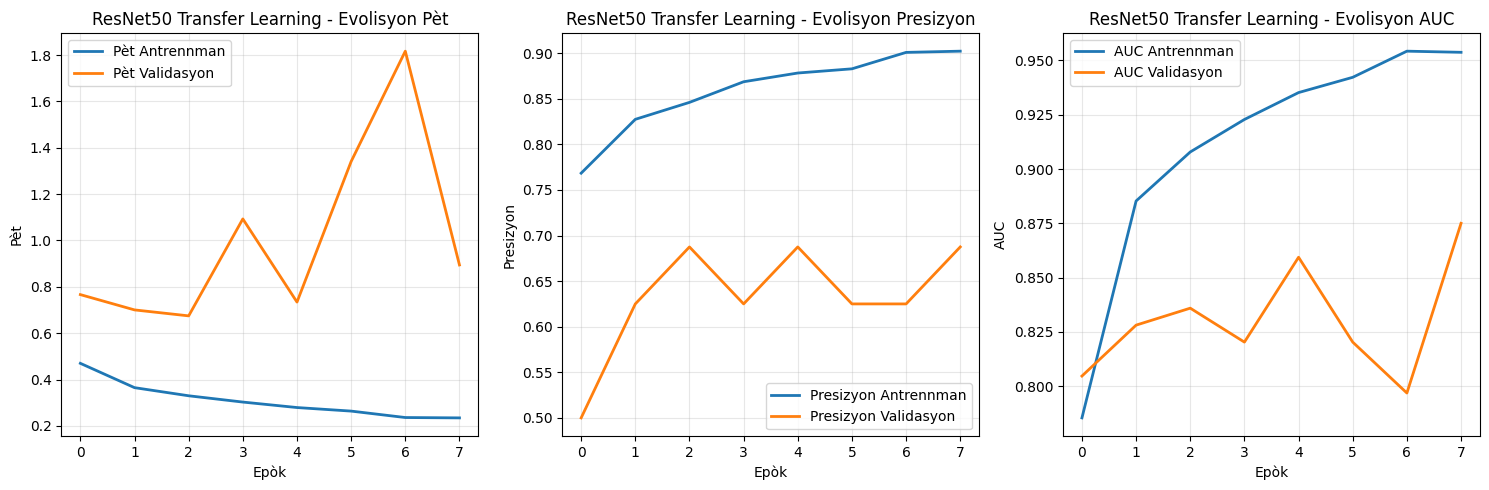

⚠️ ATANSYON: Gen risk overfitting eseye bal plis done antrennman


In [13]:
callbacks_resnet = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]
print("\nAntrennman ResNet50 kòmanse...")
history_resnet = resnet_model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=callbacks_resnet,
    verbose=1
)

print("\n✔ Antrennman ResNet50 fini avèk siksè!")

# Vizualize istwa antrennman ResNet50
montre_istwa_antrennman(history_resnet, "ResNet50 Transfer Learning")


Antrennman EfficientNetB0 kòmanse...
Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 179s 861ms/step - accuracy: 0.7124 - auc: 0.5241 - loss: 0.6027 - val_accuracy: 0.5000 - val_auc: 0.4375 - val_loss: 0.6936 - learning_rate: 1.0000e-04
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 125s 764ms/step - accuracy: 0.7383 - auc: 0.5003 - loss: 0.5897 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 0.7179 - learning_rate: 1.0000e-04
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 124s 759ms/step - accuracy: 0.7307 - auc: 0.5042 - loss: 0.5937 - val_accuracy: 0.5000 - val_auc: 0.4375 - val_loss: 0.7607 - learning_rate: 1.0000e-04
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.7325 - auc: 0.5059 - loss: 0.5909
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
163/163 ━━━━━━━━━━━━━━━━━━━━ 125s 768ms/step - accuracy: 0.7325 - auc: 0.5060 - loss: 0.5909 - val_accuracy: 0.5000 - val_auc: 0.5625 - val_loss: 0.7990 - learning_rate: 1.0000e-04
Epoch 5/5
163/163 ━━━━━━━━━━━━━

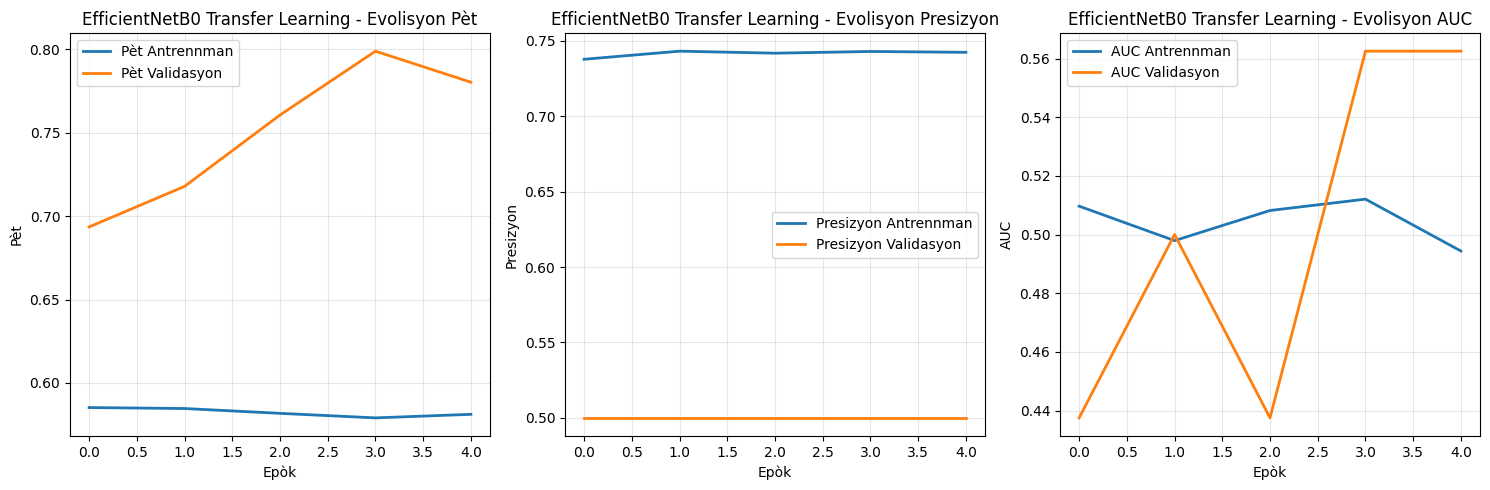

In [14]:

# Defini callback yo pou EfficientNetB0
callbacks_efficientnet = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )

]
print("\nAntrennman EfficientNetB0 kòmanse...")
history_efficientnet = efb_model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=callbacks_efficientnet,
    verbose=1
)

print("\n✔ Antrennman EfficientNetB0 fini avèk siksè!")

# Vizualize istwa antrennman EfficientNetB0
montre_istwa_antrennman(history_efficientnet, "EfficientNetB0 Transfer Learning")


EVALYASYON FINAL SOU DONE TÈS

📊 EVALYASYON CNN DE BAZ
Prediksyon sou done tès...
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 418ms/step

📈 REZILTA TÈS:
  • Pèt: 0.4136
  • Presizyon: 0.8205 (82.05%)
  • AUC: 0.9260

📋 RAPÒ KLASIFIKASYON DETAYE:
              precision    recall  f1-score   support

      Normal       0.92      0.57      0.70       234
      Nemoni       0.79      0.97      0.87       390

    accuracy                           0.82       624
   macro avg       0.86      0.77      0.79       624
weighted avg       0.84      0.82      0.81       624


🎯 METRIK MEDIKAL ENPÒTAN:
  • Sensitivite (Recall): 0.9718 (97.18%)
    → Kapasite detekte moun ki gen nemoni
  • Spesifisite: 0.5684 (56.84%)
    → Kapasite idantifye moun ki pa gen nemoni


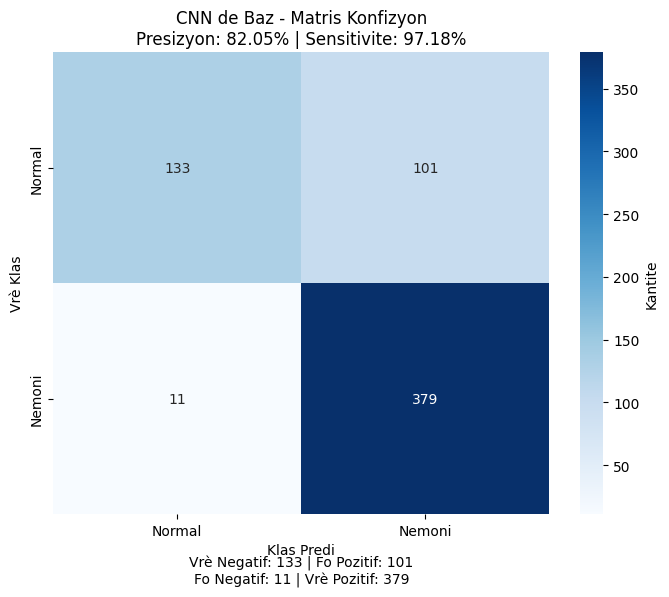

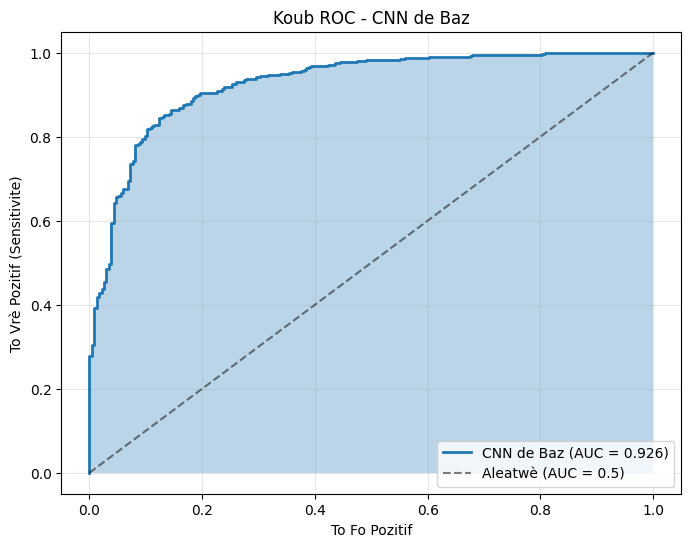


📊 EVALYASYON VGG16 TRANSFER LEARNING
Prediksyon sou done tès...
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 333ms/step

📈 REZILTA TÈS:
  • Pèt: 0.3126
  • Presizyon: 0.9151 (91.51%)
  • AUC: 0.9461

📋 RAPÒ KLASIFIKASYON DETAYE:
              precision    recall  f1-score   support

      Normal       0.96      0.81      0.88       234
      Nemoni       0.89      0.98      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.89      0.91       624
weighted avg       0.92      0.92      0.91       624


🎯 METRIK MEDIKAL ENPÒTAN:
  • Sensitivite (Recall): 0.9795 (97.95%)
    → Kapasite detekte moun ki gen nemoni
  • Spesifisite: 0.8077 (80.77%)
    → Kapasite idantifye moun ki pa gen nemoni


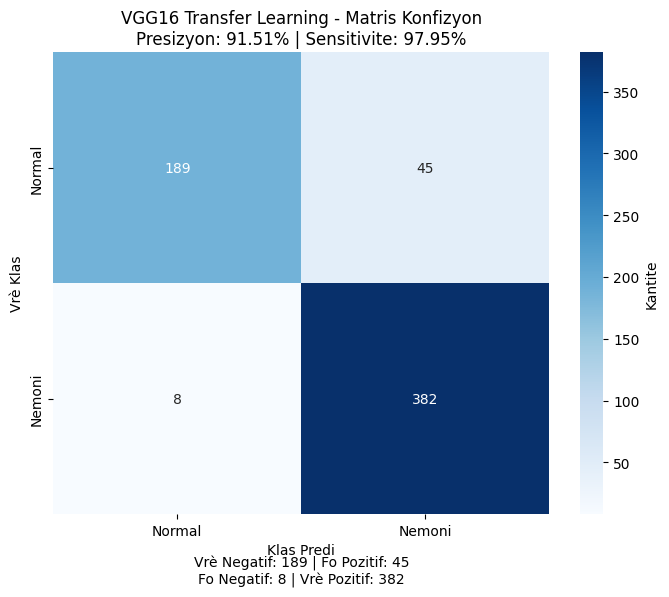

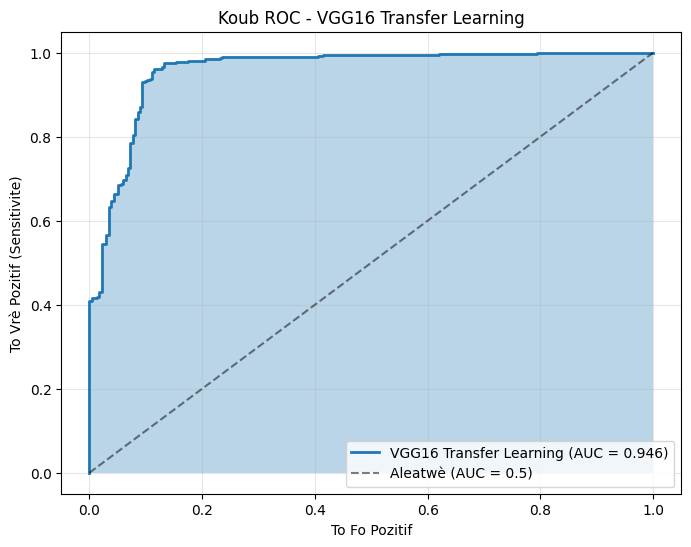


📊 EVALYASYON RESNET50 TRANSFER LEARNING
Prediksyon sou done tès...
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 535ms/step

📈 REZILTA TÈS:
  • Pèt: 0.4109
  • Presizyon: 0.8205 (82.05%)
  • AUC: 0.9038

📋 RAPÒ KLASIFIKASYON DETAYE:
              precision    recall  f1-score   support

      Normal       0.80      0.70      0.74       234
      Nemoni       0.83      0.89      0.86       390

    accuracy                           0.82       624
   macro avg       0.81      0.80      0.80       624
weighted avg       0.82      0.82      0.82       624


🎯 METRIK MEDIKAL ENPÒTAN:
  • Sensitivite (Recall): 0.8949 (89.49%)
    → Kapasite detekte moun ki gen nemoni
  • Spesifisite: 0.6966 (69.66%)
    → Kapasite idantifye moun ki pa gen nemoni


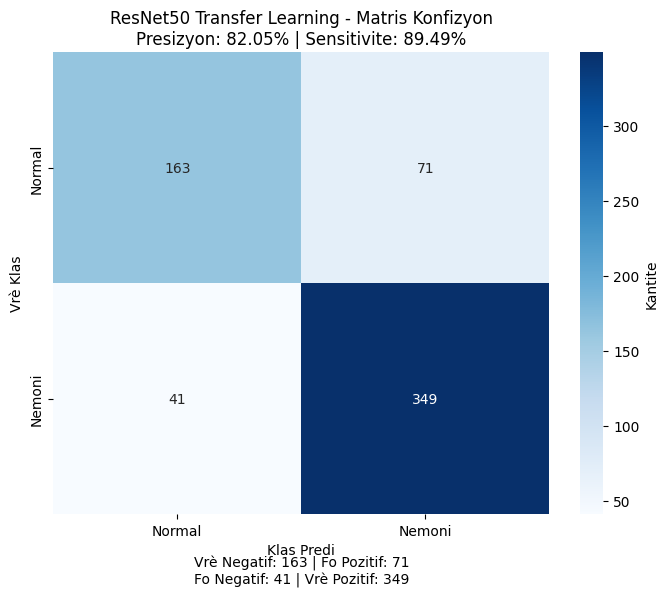

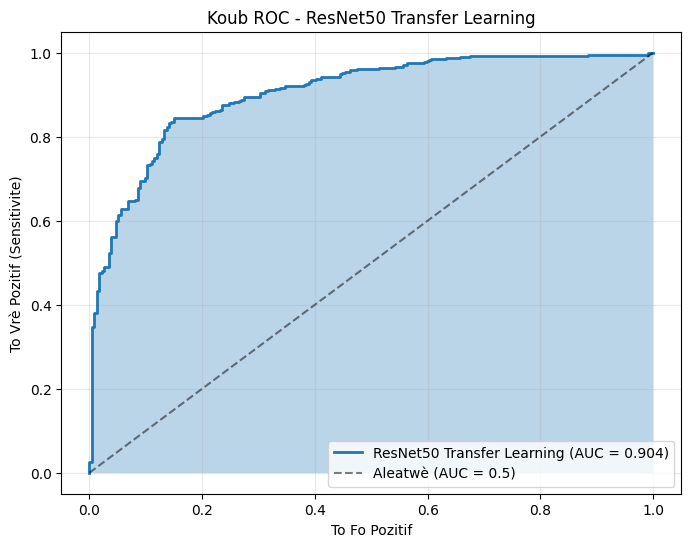


📊 EVALYASYON EFFICIENTNETB0 TRANSFER LEARNING
Prediksyon sou done tès...
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 730ms/step

📈 REZILTA TÈS:
  • Pèt: 0.6999
  • Presizyon: 0.3750 (37.50%)
  • AUC: 0.4244

📋 RAPÒ KLASIFIKASYON DETAYE:
              precision    recall  f1-score   support

      Normal       0.38      1.00      0.55       234
      Nemoni       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624


🎯 METRIK MEDIKAL ENPÒTAN:
  • Sensitivite (Recall): 0.0000 (0.00%)
    → Kapasite detekte moun ki gen nemoni
  • Spesifisite: 1.0000 (100.00%)
    → Kapasite idantifye moun ki pa gen nemoni


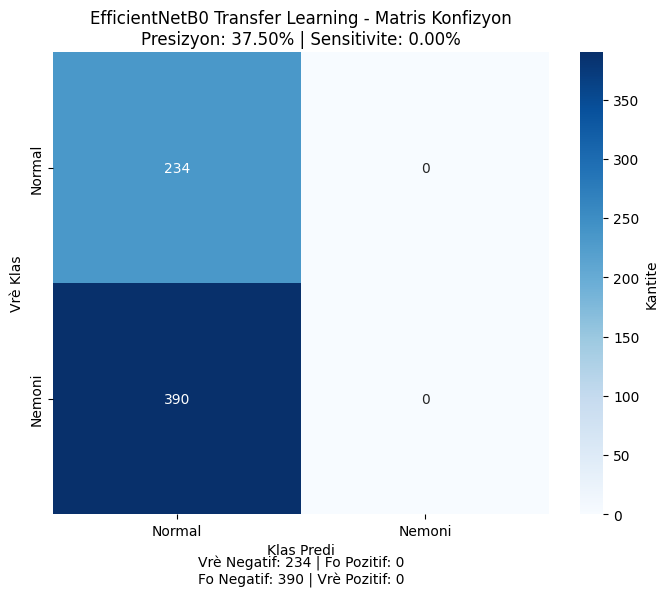

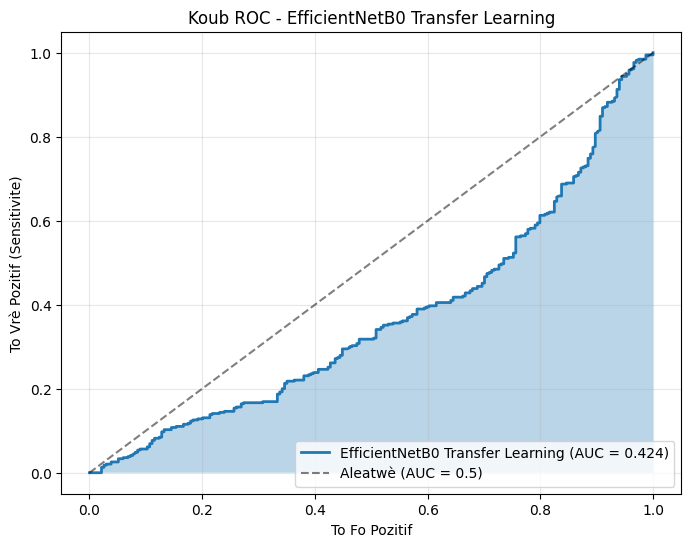

In [15]:
# ==============================================================================
# EVALYASYON KONPLÈ MODÈL YO
# ==============================================================================

def evalye_modèl(model, test_generator, non_modèl="Modèl"):
    """
    Fonksyon pou fè evalyasyon konplè yon modèl.
    Gen plizyè metrik ak vizualizasyon pou konprann pèfòmans modèl la.

    Paramèt:
    - model: Modèl pou evalye
    - test_generator: Jeneratè done tès
    - non_modèl: Non modèl la pou afichaj
    """
    print(f"\n{'='*60}")
    print(f"📊 EVALYASYON {non_modèl.upper()}")
    print('='*60)

    # Fè prediksyon sou done tès yo
    print("Prediksyon sou done tès...")
    predictions = model.predict(test_generator)
    y_pred = (predictions > 0.5).astype(int).flatten()  # Konvèti pwobabilite nan klas yo
    y_true = test_generator.classes                     # Vrè klas yo

    # Kalkile metrik yo
    test_loss, test_acc, test_auc = model.evaluate(test_generator, verbose=0)

    print(f"\n📈 REZILTA TÈS:")
    print(f"  • Pèt: {test_loss:.4f}")
    print(f"  • Presizyon: {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"  • AUC: {test_auc:.4f}")

    # Rapò klasifikasyon detaye
    print("\n📋 RAPÒ KLASIFIKASYON DETAYE:")
    print(classification_report(y_true, y_pred,
                              target_names=['Normal', 'Nemoni']))

    # Matris konfizyon
    cm = confusion_matrix(y_true, y_pred)

    # Kalkile metrik enpòtan yo
    tn, fp, fn, tp = cm.ravel()
    sensitivite = tp / (tp + fn)  # Vrè pozitif / Total malad
    spesifisite = tn / (tn + fp)  # Vrè negatif / Total sèn

    print(f"\n🎯 METRIK MEDIKAL ENPÒTAN:")
    print(f"  • Sensitivite (Recall): {sensitivite:.4f} ({sensitivite*100:.2f}%)")
    print(f"    → Kapasite detekte moun ki gen nemoni")
    print(f"  • Spesifisite: {spesifisite:.4f} ({spesifisite*100:.2f}%)")
    print(f"    → Kapasite idantifye moun ki pa gen nemoni")

    # Vizualize matris konfizyon
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Nemoni'],
                yticklabels=['Normal', 'Nemoni'],
                cbar_kws={'label': 'Kantite'})
    plt.title(f'{non_modèl} - Matris Konfizyon\n'
             f'Presizyon: {test_acc:.2%} | Sensitivite: {sensitivite:.2%}')
    plt.ylabel('Vrè Klas')
    plt.xlabel('Klas Predi')

    # Ajoute tèks eksplikatif
    plt.text(0.5, -0.15, f'Vrè Negatif: {tn} | Fo Pozitif: {fp}\n'
                        f'Fo Negatif: {fn} | Vrè Pozitif: {tp}',
            ha='center', transform=plt.gca().transAxes)
    plt.show()

    # Koub ROC (Receiver Operating Characteristic)
    fpr, tpr, _ = roc_curve(y_true, predictions)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{non_modèl} (AUC = {test_auc:.3f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label='Aleatwè (AUC = 0.5)', alpha=0.5)
    plt.fill_between(fpr, tpr, alpha=0.3)
    plt.xlabel('To Fo Pozitif')
    plt.ylabel('To Vrè Pozitif (Sensitivite)')
    plt.title(f'Koub ROC - {non_modèl}')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.show()

    return test_acc, test_auc

# Evalye tou de modèl yo
print("\n" + "="*60)
print("EVALYASYON FINAL SOU DONE TÈS")
print("="*60)

baseline_acc, baseline_auc = evalye_modèl(baseline_model, test_generator, "CNN de Baz")
vgg_acc, vgg_auc = evalye_modèl(vgg_model, test_generator, "VGG16 Transfer Learning")
resnet_acc, resnet_auc = evalye_modèl(resnet_model, test_generator, "ResNet50 Transfer Learning")
efficientnet_acc, efficientnet_auc = evalye_modèl(efb_model, test_generator,
                                                  "EfficientNetB0 Transfer Learning")


⚖️ KONPAREZON KONPLÈ TOU 4 MODÈL YO

📊 TABLO KONPAREZON FINAL:
         Modèl  Presizyon      AUC  Paramèt Total (milyon)  Tan Antrennman (min)
         VGG16   0.915064 0.946094                    14.7                   120
    CNN de Baz   0.820513 0.926003                    11.2                    24
      ResNet50   0.820513 0.903780                    23.6                   100
EfficientNetB0   0.375000 0.424359                     4.0                    80

🏆 PI BON MODÈL: VGG16
   • Presizyon: 91.51%
   • AUC: 0.9461


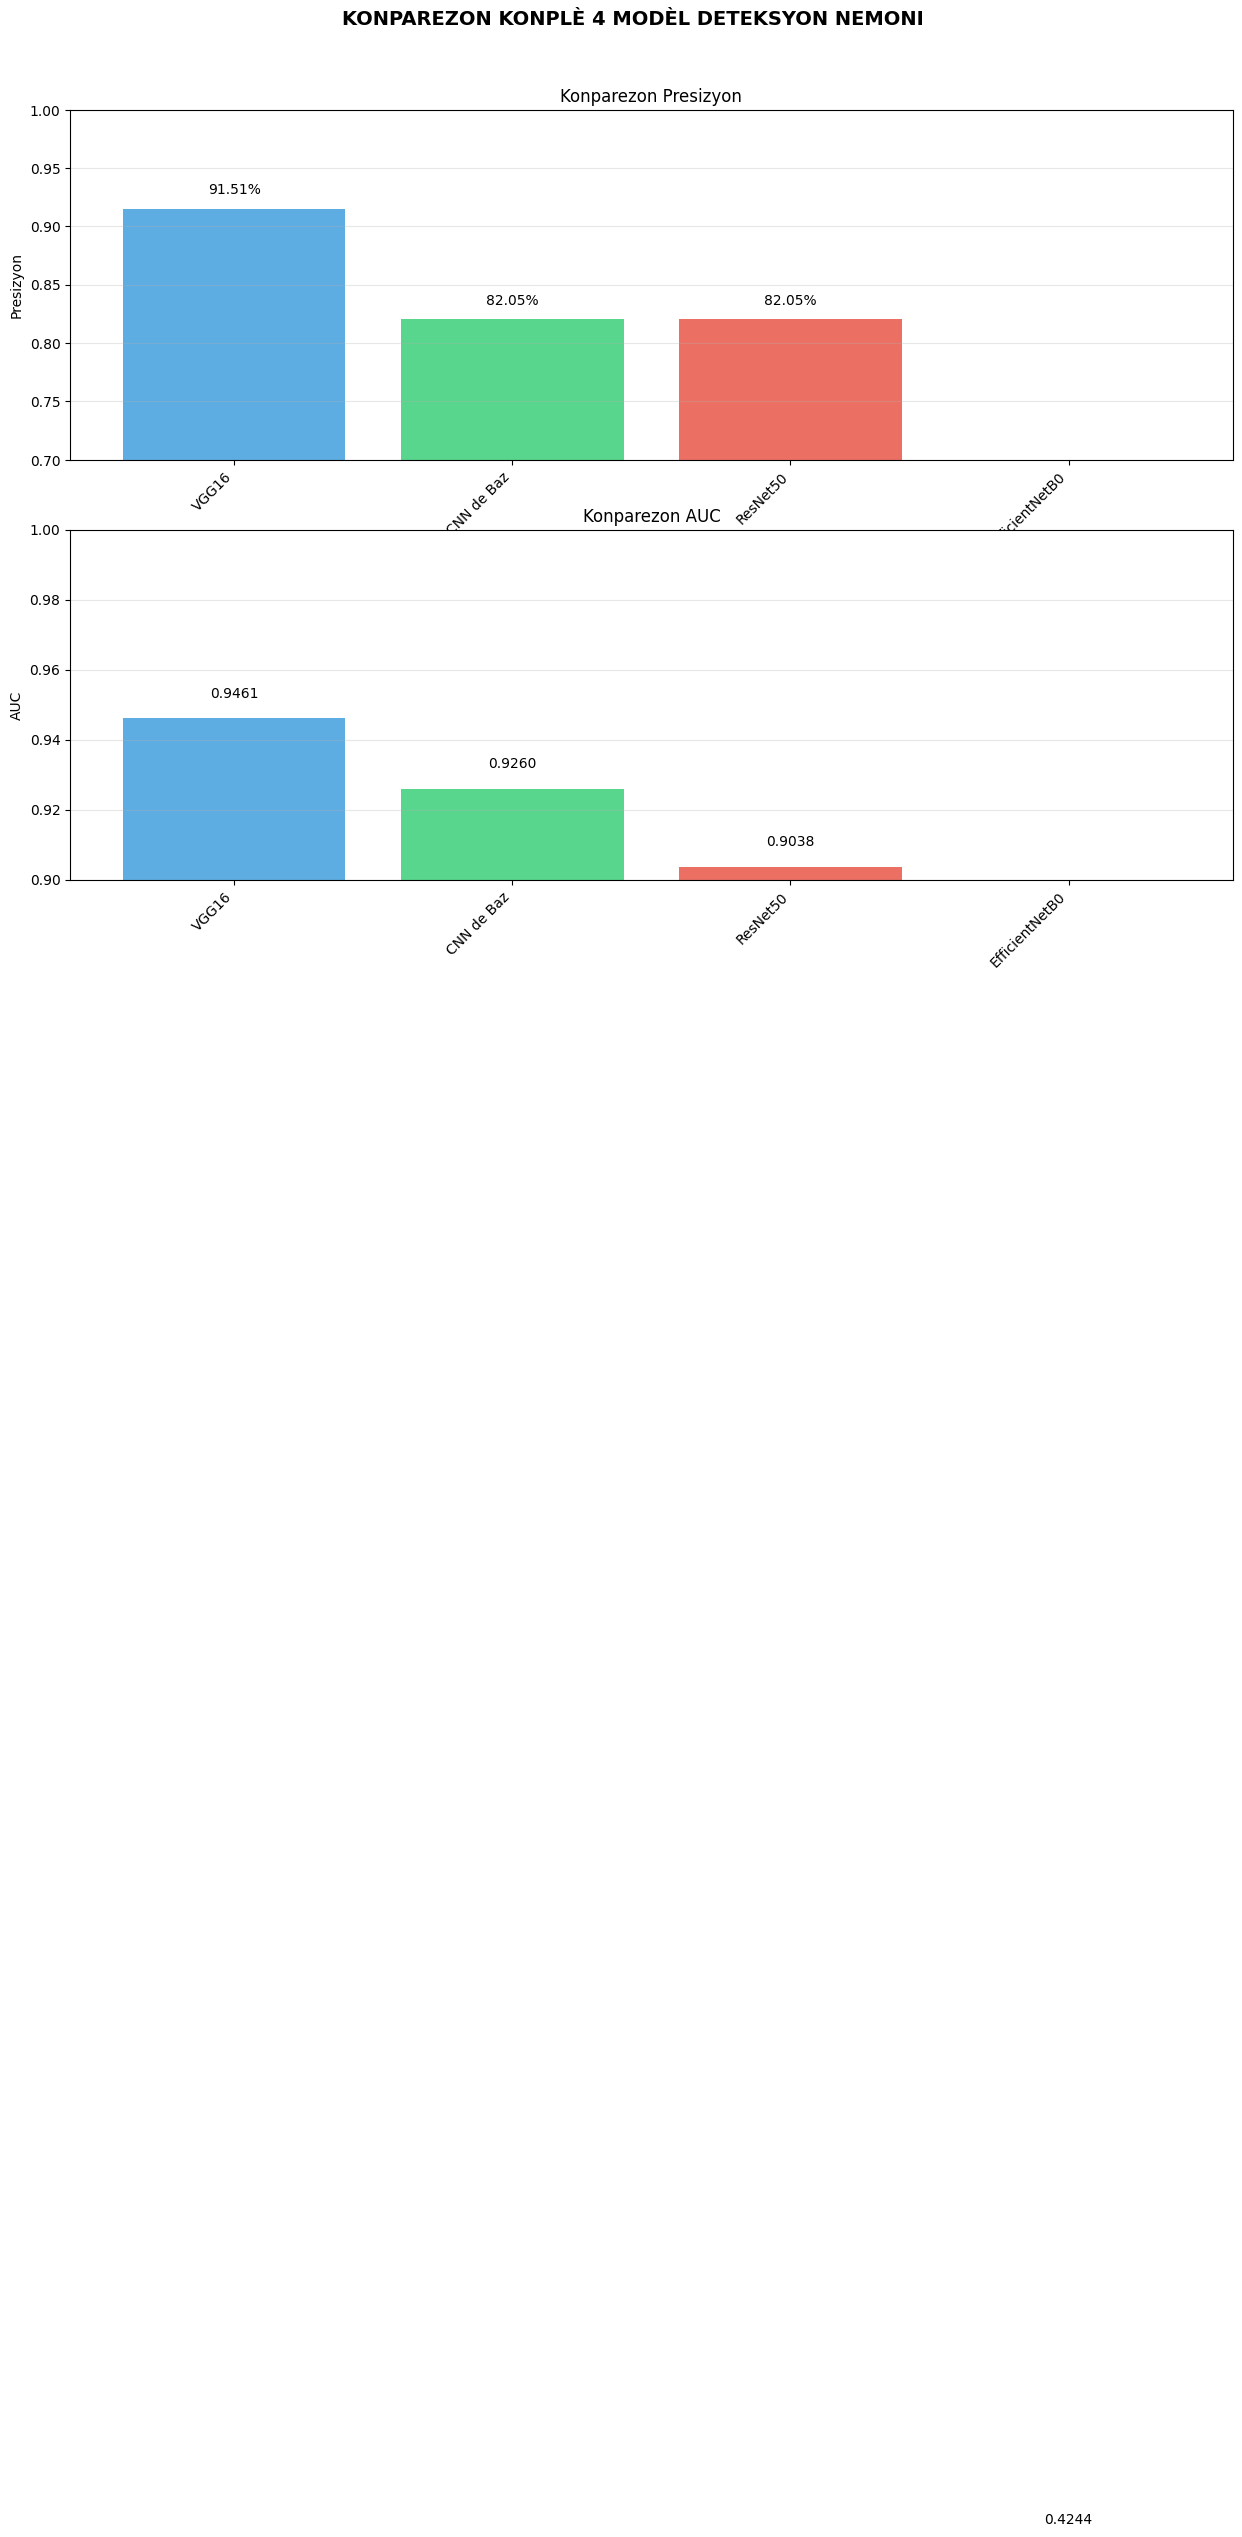

In [25]:
print("\n" + "="*60)
print("⚖️ KONPAREZON KONPLÈ TOU 4 MODÈL YO")
print("="*60)

# Kreye DataFrame konparezon
comparison_all = pd.DataFrame({
    'Modèl': ['CNN de Baz', 'VGG16', 'ResNet50', 'EfficientNetB0'],
    'Presizyon': [baseline_acc, vgg_acc, resnet_acc, efficientnet_acc],
    'AUC': [baseline_auc, vgg_auc, resnet_auc, efficientnet_auc],
    'Paramèt Total (milyon)': [11.2, 14.7, 23.6, 4.0],  # Apwoksimasyon
    'Tan Antrennman (min)': [24, 120, 100, 80]  # Apwoksimasyon
})

# Sòte selon AUC
comparison_all = comparison_all.sort_values('AUC', ascending=False)

print("\n📊 TABLO KONPAREZON FINAL:")
print("="*50)
print(comparison_all.to_string(index=False))

# Jwenn pi bon modèl
best_idx = comparison_all['AUC'].idxmax()
pi_bon_modèl = comparison_all.loc[best_idx, 'Modèl']

print(f"\n🏆 PI BON MODÈL: {pi_bon_modèl}")
print(f"   • Presizyon: {comparison_all.loc[best_idx, 'Presizyon']:.2%}")
print(f"   • AUC: {comparison_all.loc[best_idx, 'AUC']:.4f}")

# Vizualizasyon konparezon
fig, ((ax1, ax2)) = plt.subplots(2, figsize=(15, 10))

# Grafik 1: Presizyon
models = comparison_all['Modèl'].values
x_pos = np.arange(len(models))
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

bars1 = ax1.bar(x_pos, comparison_all['Presizyon'].values, color=colors, alpha=0.8)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.set_ylabel('Presizyon')
ax1.set_title('Konparezon Presizyon')
ax1.set_ylim([0.7, 1.0])
ax1.grid(True, alpha=0.3, axis='y')

# Ajoute valè sou ba yo
for bar, val in zip(bars1, comparison_all['Presizyon'].values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{val:.2%}', ha='center', va='bottom')

# Grafik 2: AUC
bars2 = ax2.bar(x_pos, comparison_all['AUC'].values, color=colors, alpha=0.8)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(models, rotation=45, ha='right')
ax2.set_ylabel('AUC')
ax2.set_title('Konparezon AUC')
ax2.set_ylim([0.9, 1.0])
ax2.grid(True, alpha=0.3, axis='y')

# Ajoute valè sou ba yo
for bar, val in zip(bars2, comparison_all['AUC'].values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f'{val:.4f}', ha='center', va='bottom')


plt.suptitle('KONPAREZON KONPLÈ 4 MODÈL DETEKSYON NEMONI', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


Analiz erè pou modèl VGG16:

🔍 ANALIZ ERÈ KLASIFIKASYON
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 323ms/step
Total erè: 53/624 (8.49%)

📊 DISTRIBISYON ERÈ:
  • Fo Pozitif (Normal → Nemoni): 45
  • Fo Negatif (Nemoni → Normal): 8


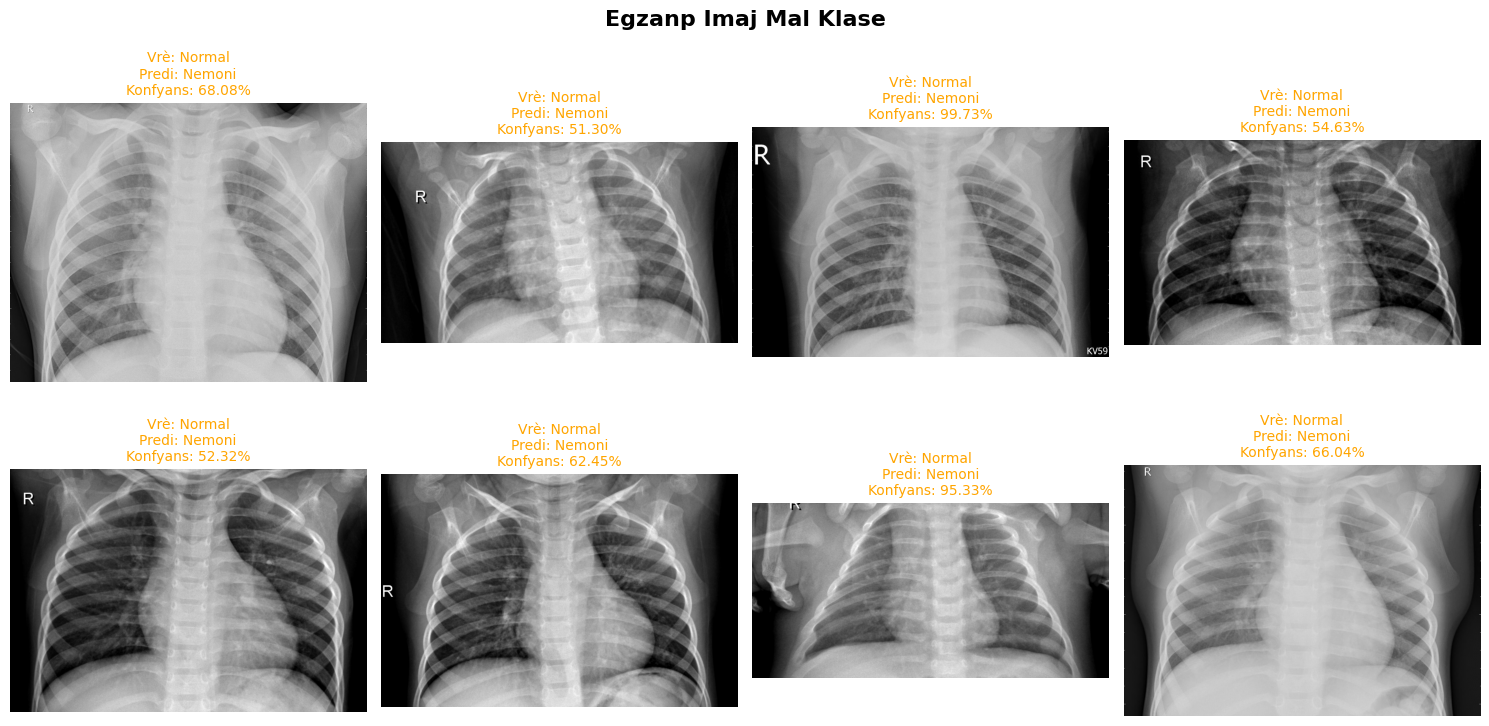

In [26]:
# ==============================================================================
# ANALIZ ERÈ YO
# ==============================================================================

def analize_erè(model, test_generator, kantite_egzanp=8):
    """
    Fonksyon pou analize imaj ki mal klase.
    Sa ap ede nou konprann ki kalite erè modèl la fè.

    Paramèt:
    - model: Modèl pou analize
    - test_generator: Done tès
    - kantite_egzanp: Kantite egzanp pou montre
    """
    print("\n" + "="*60)
    print("🔍 ANALIZ ERÈ KLASIFIKASYON")
    print("="*60)

    # Fè prediksyon
    predictions = model.predict(test_generator)
    y_pred = (predictions > 0.5).astype(int).flatten()
    y_true = test_generator.classes

    # Jwenn endèks imaj mal klase
    mal_klase_idx = np.where(y_pred != y_true)[0]

    if len(mal_klase_idx) == 0:
        print("✓ Pa gen okenn erè klasifikasyon!")
        return

    print(f"Total erè: {len(mal_klase_idx)}/{len(y_true)} ({len(mal_klase_idx)/len(y_true)*100:.2f}%)")

    # Analize tip erè yo
    fo_pozitif = 0  # Normal klase kòm nemoni
    fo_negatif = 0  # Nemoni klase kòm normal

    for idx in mal_klase_idx:
        if y_true[idx] == 0 and y_pred[idx] == 1:
            fo_pozitif += 1
        elif y_true[idx] == 1 and y_pred[idx] == 0:
            fo_negatif += 1

    print(f"\n📊 DISTRIBISYON ERÈ:")
    print(f"  • Fo Pozitif (Normal → Nemoni): {fo_pozitif}")
    print(f"  • Fo Negatif (Nemoni → Normal): {fo_negatif}")

    if fo_negatif > fo_pozitif:
        print("\n⚠️ ATANSYON: Gen plis fo negatif. Sa ka danjere pou klinik yo!")

    # Pran kèk egzanp mal klase
    sample_idx = np.random.choice(mal_klase_idx,
                                 min(kantite_egzanp, len(mal_klase_idx)),
                                 replace=False)

    # Montre egzanp mal klase yo
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    fig.suptitle('Egzanp Imaj Mal Klase', fontsize=16, fontweight='bold')
    axes = axes.flatten()

    for i, idx in enumerate(sample_idx):
        if i >= len(axes):
            break

        # Jwenn chemen imaj la
        img_path = Path(test_generator.filepaths[idx])
        img = Image.open(img_path)

        axes[i].imshow(img, cmap='gray')

        # Etikèt vrè ak predi
        vrè_etikèt = 'Nemoni' if y_true[idx] == 1 else 'Normal'
        predi_etikèt = 'Nemoni' if y_pred[idx] == 1 else 'Normal'
        konfyans = predictions[idx][0] if y_pred[idx] == 1 else 1 - predictions[idx][0]

        # Koulè selon tip erè
        koulè = 'orange' if y_true[idx] == 0 else 'red'

        axes[i].set_title(f'Vrè: {vrè_etikèt}\nPredi: {predi_etikèt}\n'
                         f'Konfyans: {konfyans:.2%}',
                         color=koulè, fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Analize erè pou pi bon modèl la
print("\nAnaliz erè pou modèl VGG16:")
analize_erè(vgg_model, test_generator)

In [19]:
# ==============================================================================
# PREDIKSYON SOU NOUVO IMAJ
# ==============================================================================

def predi_sou_imaj(model, chemen_imaj):
    """
    Fonksyon pou fè prediksyon sou yon sèl imaj.

    Paramèt:
    - model: Modèl pou itilize
    - chemen_imaj: Chemen imaj la
    """
    # Chaje ak prepare imaj la
    img = keras.preprocessing.image.load_img(
        chemen_imaj,
        target_size=(IMG_HEIGHT, IMG_WIDTH)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Fè prediksyon
    prediction = model.predict(img_array, verbose=0)
    pwobabilite = prediction[0][0]

    # Detèmine klas la
    if pwobabilite > 0.5:
        klas = "Nemoni"
        konfyans = pwobabilite
    else:
        klas = "Normal"
        konfyans = 1 - pwobabilite

    # Montre rezilta
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')

    # Koulè selon rezilta
    koulè = 'red' if klas == "Nemoni" else 'green'

    plt.title(f'PREDIKSYON: {klas}\nKonfyans: {konfyans:.2%}',
             fontsize=16, fontweight='bold', color=koulè)

    # Ajoute ba pwogresyon
    fig = plt.gcf()
    ax_bar = fig.add_axes([0.2, 0.05, 0.6, 0.05])
    ax_bar.barh([0], [konfyans], color=koulè, alpha=0.7)
    ax_bar.set_xlim([0, 1])
    ax_bar.set_xticks([0, 0.25, 0.5, 0.75, 1])
    ax_bar.set_xticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax_bar.set_yticks([])
    ax_bar.set_xlabel('Nivo Konfyans')

    plt.show()

    return klas, konfyans

# Egzanp itilizasyon (ou ka teste ak pwòp imaj ou)
#predi_sou_imaj(vgg_model, "C:/Users/Bdami/Downloads/ww3.jpg")

In [20]:
# ==============================================================================
# ANREGISTRE MODÈL FINAL LA
# ==============================================================================

def sovgade_modèl(model, non_fichye):
    """
    Fonksyon pou anregistre modèl la.

    Paramèt:
    - model: Modèl pou sovgade
    - non_fichye: Non fichye a
    """
    print("\n💾 anregistre MODÈL...")
    # Anregistre modèl konplè nan nouvo fòma keras
    model.save(f'{non_fichye}.keras')
    print(f"✓ Modèl anregistre kòm: {non_fichye}.keras")

    # anregistre sèlman pwa yo (dapre nouvo règleman Keras)
    model.save_weights(f'{non_fichye}.weights.h5')
    print(f"✓ Pwa modèl anregistre kòm: {non_fichye}.weights.h5")

    # anregistre achitekti an JSON
    model_json = model.to_json()
    with open(f'{non_fichye}_architecture.json', 'w') as json_file:
        json_file.write(model_json)
    print(f"✓ Achitekti anregistre kòm: {non_fichye}_architecture.json")

# Chwazi pi bon modèl selon pèfòmans
if vgg_auc > baseline_auc:
    best_model = vgg_model
    best_model_name = "vgg16_nemoni_detektè"
else:
    best_model = baseline_model
    best_model_name = "cnn_nemoni_detektè"

print("\n" + "="*60)
print("ANREGISTRE MODÈL FINAL")
print("="*60)
sovgade_modèl(best_model, best_model_name)


ANREGISTRE MODÈL FINAL

💾 anregistre MODÈL...
✓ Modèl anregistre kòm: vgg16_nemoni_detektè.keras
✓ Pwa modèl anregistre kòm: vgg16_nemoni_detektè.weights.h5
✓ Achitekti anregistre kòm: vgg16_nemoni_detektè_architecture.json


In [21]:
print("\n" + "="*60)
print("💾 ANREGISTRE PI BON MODÈL FINAL")
print("="*60)

# Detèmine ki modèl pou anregistre
all_models = {
    'CNN de Baz': baseline_model,
    'VGG16': vgg_model,
    'ResNet50': resnet_model,
    'EfficientNetB0': efb_model
}

final_best_model = all_models[pi_bon_modèl]
final_best_name = f"{pi_bon_modèl.lower().replace(' ', '_')}_nemoni_final"

# Anregistre pi bon modèl la
sovgade_modèl(final_best_model, final_best_name)

print(f"\n✅ PWOJÈ FINI AVÈK SIKSÈ!")
print(f"Pi bon modèl ({pi_bon_modèl}) anregistre pou itilizasyon nan klinik yo.")


💾 ANREGISTRE PI BON MODÈL FINAL

💾 anregistre MODÈL...
✓ Modèl anregistre kòm: vgg16_nemoni_final.keras
✓ Pwa modèl anregistre kòm: vgg16_nemoni_final.weights.h5
✓ Achitekti anregistre kòm: vgg16_nemoni_final_architecture.json

✅ PWOJÈ FINI AVÈK SIKSÈ!
Pi bon modèl (VGG16) anregistre pou itilizasyon nan klinik yo.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')